# Topic Classification and Trend Visualization

## Data Preparation
- Extracted **Title** and **Abstract** from the `authors.leptospirosis.csv` file to analyze topics.

## Topic Classification
1. Initially attempted to classify into **10 topics**, but some articles were not assigned (values were 0).  
2. Reduced the number of topics and successfully classified into **6 topics**.  
3. Interpreted the content of each topic to identify key characteristics and themes.

## Yearly Trend Analysis
1. Counted the yearly occurrences for each topic.  
2. Visualized the yearly proportions of topics using a **Stacked Area Chart** to show trends over time.

## Purpose of Visualization
- To observe the rise and fall of research topics at a glance.  
- To highlight the importance of specific topics during certain periods and clarify how research priorities shifted over time.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import plotly.express as px
import plotly.graph_objects as go

In [39]:
# Reading the CSV files
articles_df = pd.read_csv('../data/articles.leptospirosis.csv')
authors_df = pd.read_csv('../data/authors.leptospirosis.csv')
paper_counts_df = pd.read_csv('../data/paper_counts.csv')

# display(articles_df.head())
# display(authors_df.head())
# display(paper_counts_df.head())

# # Check the data types and basic structure of the dataframes
# print(articles_df.info())
# print(authors_df.info())
# print(paper_counts_df.info())

# # Check for missing values in each dataset
# print(articles_df.isnull().sum())
# print(authors_df.isnull().sum())
# print(paper_counts_df.isnull().sum())

In [40]:
# Drop rows with missing values in specific columns
# Remove rows with missing values in the articles DataFrame
articles_df_cleaned = articles_df.dropna()
authors_df_cleaned = authors_df.dropna()
paper_counts_df_cleaned = paper_counts_df.dropna()

# Drop duplicate rows
articles_df.drop_duplicates(inplace=True)
authors_df.drop_duplicates(inplace=True)
paper_counts_df.drop_duplicates(inplace=True)

# # Check if there are any missing values left
# print(articles_df.isnull().sum())
# print(authors_df.isnull().sum())

In [41]:
# Check the data types of each column
# print(articles_df_cleaned.dtypes)

# Example of type conversion if needed
articles_df_cleaned.loc[:, 'Year'] = articles_df_cleaned['Year'].astype(int)

In [42]:
num_topics = 6

# Combine the title and abstract into a single text column
articles_df['Text'] = articles_df['Title'].fillna('') + ' ' + articles_df['Abstract'].fillna('')

# Set up the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf_vectorizer.fit_transform(articles_df['Text'])

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Get the topic distribution for each document
topic_distribution = lda.transform(X)

# Assign each document to its most likely topic
topic_assignments = topic_distribution.argmax(axis=1)

In [43]:
# Muted/soft colors for the line plot
color_sequence = [
    '#b4a7d6',  # Light Purple
    '#c27ba0',  # Greige (Grayish Beige)
    '#9fc5e8',  # Light Blue
    '#b6d7a8',  # Light Green
    '#ffd966',  # Dark Yellow
    '#f4cccc',  # Light Pink
    '#ce7e00',  # Dark Brown
    '#d9d9d6',  # Light Gray
    '#444444',  # Dark Gray
    '#a52a2a',  # Brown
]

# Extracting the top words for each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Get top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    topic_words.append(top_words)

# Topic summaries (short descriptions based on top words)
topic_summaries = {}
for i, words in enumerate(topic_words):
    summary = f"Topic {i+1}: " + ", ".join(words)  # Create summary from top 10 words
    topic_summaries[i] = summary
    print(summary)

# Group the topic distribution by year and calculate the total number of articles per topic per year
articles_df['Year'] = articles_df['Year'].astype(int)

topic_by_year = pd.DataFrame(topic_distribution, columns=[f'Topic {i+1}' for i in range(lda.n_components)])
topic_by_year['Year'] = articles_df['Year']
topic_by_year_count = topic_by_year.groupby('Year').sum()  # Total number of articles for each topic per year

# Calculate total articles per year
total_articles_per_year = topic_by_year_count.sum(axis=1)

"""
Stacked Bar Plot:
Total number of articles for each topic by year
"""
# Create the bar plot with actual article counts (not proportions)
fig = px.bar(
    topic_by_year_count,
    x=topic_by_year_count.index,
    y=topic_by_year_count.columns,
    labels={"x": "Year", "value": "Number of Articles", "variable": "Topics"},
    title="Number of Articles by Topic Over Time",
    template="plotly_white",
    color_discrete_sequence=color_sequence  # Apply the custom muted color sequence directly
)

# Update the hover info to show the topic summary on hover
for i, col in enumerate(topic_by_year_count.columns):
    fig.data[i].name = topic_summaries[i]  # Assign topic summaries as hover labels

# Customize layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Articles",
    barmode='stack',
    hovermode='x unified',
    width=1200,
    height=600,
    legend=dict(
      yanchor='bottom',
      xanchor='center'
  )
)

fig.show()


print(topic_by_year_count)


Topic 1: assay, test, pcr, diagnosis, elisa, leptospirosis, vaccine, detection, mat, igm
Topic 2: sri, lanka, hantavirus, deer, zealand, cows, farm, bovine, dairy, herds
Topic 3: leptospirosis, patients, severe, acute, clinical, case, pulmonary, renal, failure, fever
Topic 4: leptospira, interrogans, proteins, protein, pathogenic, leptospiral, host, expression, cells, immune
Topic 5: leptospirosis, leptospira, risk, disease, study, cases, animals, dogs, human, factors
Topic 6: typhus, diseases, scrub, leptospirosis, health, infections, fever, malaria, india, review


        Topic 1   Topic 2    Topic 3    Topic 4     Topic 5    Topic 6
Year                                                                  
1944   0.027814  0.027520   0.028085   0.199281    0.689672   0.027628
1945   0.157720  0.030951   0.032183   0.716800    0.031251   0.031095
1960   0.054114  0.053396   0.565566   0.053765    1.219310   0.053848
1961   0.107050  0.106390   0.108041   0.341308    3.177790   0.159422
1963   0.028295  0.028103   0.436832   0.450205    0.028350   0.028216
1964   0.894154  0.054331   0.055507   0.054798    0.886785   0.054426
1970   0.133448  0.132029   0.136205   1.737118    1.728610   0.132590
1976   0.066353  0.065972   0.066483   0.067077    1.667944   0.066172
1977   0.032056  0.032736   0.031943   0.031842    0.839583   0.031841
1981   0.029501  0.029394   0.029713   0.029475    0.852364   0.029554
1982   0.345783  0.100323   0.099933   0.099541    3.254903   0.099517
1984   0.041807  0.040954   0.041419   0.041985    1.792889   0.040946
1985  

## Yearly Topic Trends (Important Topics Only)

### 1944
- **Topic 5**: High value (0.689672).  
  Focus on animal studies related to leptospirosis.

### 1945
- **Topic 4**: Highest value (0.716800).  
  Likely focused on inflammatory cytokine response.

### 1960
- **Topic 5**: Very high value (1.219310).  
  Continued research on leptospirosis in animals.

### 1961
- **Topic 6**: Highest value (3.177790).  
  Emphasis on zoonotic aspects and human impact.

### 1963
- **Topic 3**: Notable (0.436832).  
  Progress in severe case studies.

### 1964
- **Topic 1**: Very high value (0.894154).  
  Active research on diagnostic methods.

### 1970
- **Topic 4**: Highest value (1.737118).  
  Continued focus on inflammatory response research.

### 1981–1982
- **Topic 2** and **Topic 5**: Significant.  
  Focused on Leptospira proteins, pathogenicity, and animal risks.

### 1990s
- **Topic 3** and **Topic 6**: Noticeable increase.  
  More research on severe clinical cases and human impact.

### Early 2000s
- **Topic 6**: Outstanding increase, especially from 2000 to 2005 (maximum ~30).  
  Highlighted human health risks.

### Late 2000s
- **Topic 3**: Gained attention.  
  Active studies on acute clinical symptoms and severe patients.

### 2010s
- **Topic 5** and **Topic 6**: Recorded high values.  
  Research expanded on animal risks and human impact.

### 2020s
- **Topic 6**: Continued to rise (exceeding 100).  
  Emphasized as a public health issue with a strong focus on zoonotic risks.

In [44]:
# Function to calculate the overlap between topics
def get_topic_overlap(lda, tfidf_vectorizer, num_topics):
    words = np.array(tfidf_vectorizer.get_feature_names_out())
    topic_vectors = []

    # Construct topic vectors using the highest-weighted words
    for topic in lda.components_:
        topic_vector = np.zeros(len(words))
        for idx in topic.argsort()[-30:]:  # Top 30 words for each topic
            topic_vector[idx] = topic[idx]
        topic_vectors.append(topic_vector)

    similarity_matrix = cosine_similarity(topic_vectors)
    return similarity_matrix, words

# Calculate the topic similarity and get the words
similarity_matrix, words = get_topic_overlap(lda, tfidf_vectorizer, num_topics)

# Create a dataframe to hold the x and y coordinates for the circles
topic_positions = np.random.rand(num_topics, 2)  # Random initial positions for topics

# Define a list of colors (you can modify this or use a color palette)
colors = [
    '#b4a7d6',  # Light Purple
    '#c27ba0',  # Greige (Grayish Beige)
    '#9fc5e8',  # Light Blue
    '#b6d7a8',  # Light Green
    '#ffd966',  # Dark Yellow
    '#f4cccc',  # Light Pink
    '#ce7e00',  # Dark Brown
    '#d9d9d6',  # Light Gray
    '#444444',  # Dark Gray
    '#a52a2a',  # Brown
]

# Create the plotly figure
fig = go.Figure()

# Add circles for each topic with distinct colors
for i in range(num_topics):
    # Use a random position for each circle
    x_pos, y_pos = topic_positions[i]

    # Add the circle for the current topic with a specific color
    fig.add_trace(go.Scatter(
        x=[x_pos], y=[y_pos], mode="markers", marker=dict(
            size=90, opacity=0.6, line=dict(width=2, color="black"),
            symbol="circle", color=colors[i], sizemode="diameter"),
        name=f"Topic {i + 1}"
    ))

    # Get the top 30 words for the current topic
    top_words = [words[idx] for idx in lda.components_[i].argsort()[-30:]]

    # Add the topic name with top words to the legend (display only the name)
    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode="text", text=[f"Topic {i + 1}: " + ', '.join(top_words)],
        showlegend=True, name=f"Topic {i + 1}"
    ))

# Overlay the circles based on similarity
for i in range(num_topics):
    for j in range(i + 1, num_topics):
        similarity_score = similarity_matrix[i, j]

        if similarity_score > 0.5:  # Only draw lines for significant overlaps

            # Calculate the overlap based on the similarity score
            x_overlap = [topic_positions[i][0], topic_positions[j][0]]
            y_overlap = [topic_positions[i][1], topic_positions[j][1]]

            # Draw a line (representing overlap) between the topics
            fig.add_trace(go.Scatter(
                x=x_overlap, y=y_overlap, mode='lines', line=dict(width=2, color="black"),
                opacity=similarity_score, showlegend=False
            ))

# Set layout to make it more readable and reduce the size of the plot
fig.update_layout(
    title="Topic Overlap Visualization with Color Coding and Top 30 Words in Legend",
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    showlegend=True,
    plot_bgcolor="white",
    width=600,
    height=600
)

fig.show()


In [45]:
# Step 2: Create a full name for each author
# Replace NaN values with an empty string and combine first name, last name, and initials
authors_df['FullName'] = authors_df['AuthorForename'].fillna('') + ' ' + authors_df['AuthorLastname'].fillna('')

# Step 3: Combine all authors for a given PMID
# Group by PMID and join authors' full names into a single string
author_fullnames = authors_df.groupby('PMID')['FullName'].apply(lambda x: ', '.join(x)).reset_index()

# Step 4: Extract topic distribution scores for each article
topic_distribution = lda.transform(X)

# Step 5: Extract top articles for each topic based on relevance scores
num_top_articles = 100  # Number of top articles to extract per topic

top_articles_per_topic = {}

for topic_idx in range(lda.n_components):
    # Skip topic 4 (index 3) as requested
    if topic_idx == 0 or topic_idx == 1 or topic_idx == 3:
        continue

    # Get the relevance scores for each article with respect to the current topic
    topic_scores = topic_distribution[:, topic_idx]

    # Get the indices of the top articles sorted by highest relevance
    top_article_indices = topic_scores.argsort()[-num_top_articles:][::-1]

    # Extract the titles and other info of the top articles for the current topic
    top_articles = articles_df.iloc[top_article_indices][['Title', 'Year', 'PMID']]

    # Extract authors' full names for the top articles
    top_articles['Authors'] = top_articles['PMID'].map(
        lambda pmid: author_fullnames[author_fullnames['PMID'] == pmid]['FullName'].values[0]
    )

    # Store the result in the dictionary
    top_articles_per_topic[topic_idx] = top_articles

# Step 6: Display the results for each topic and aggregate authors' names across all topics
all_authors_series = pd.Series(dtype='str')

for topic_idx, top_articles in top_articles_per_topic.items():
    print(f"Topic {topic_idx+1}:")
    display(top_articles[['Title', 'Authors', 'Year']])

    # Collect authors from each topic
    authors_series = top_articles['Authors'].str.split(', ', expand=True).stack()
    all_authors_series = pd.concat([all_authors_series, authors_series], ignore_index=True)

# Count the frequency of each author across all topics
authors_count_total = all_authors_series.value_counts().reset_index()
authors_count_total.columns = ['Author', 'Count']

# Step 7: Display the total counts of authors sorted by frequency
print("Total Author Frequency Across Topic 3,5,6:")
display(authors_count_total.head(20))


Topic 3:


,Title,Authors,Year
1289,Severe leptospirosis: treatment with intraveno...,"Kyle Minor, Arun Mohan",2013
3218,Case Report: An Imported Case of Severe Leptos...,"Takao Goto, Rentaro Oda, Yasuhiro Norisue, Nob...",2023
3254,Case report: Leptospirosis with multi-organ fa...,"Mariam Thalji, Hanan Qunibi, Loai Muhtasib, Ha...",2023
1031,Clinical and imaging manifestations of hemorrh...,"Edson Marchiori, Sílvia Lourenço, Sérgio Setúb...",2011
2012,Leptospirosis Presenting with Rapidly Progress...,"Pallavi Pothuri, Keerat Ahuja, Viki Kumar, Sha...",2016
...,...,...,...
1881,Acute Respiratory Distress Syndrome Manifested...,"Chen-Yi Liao, Ren-Jy Ben, Hau-Ming Wu, Shih-Ku...",2015
1496,Leptospirosis and dengue fever: a predictive m...,"Muralidhar D Varma, Seena Vengalil, Saraschand...",2014
70,[Febrile cytolysis disclosing hemorrhagic feve...,"E Rassiat, E Barrière, A Minello, J Jouve, P H...",2000
1115,Clinical manifestations of co-infection with m...,"Mohan Gurjar, Saurabh Saigal, Arvind K Baronia...",2011


Topic 5:


,Title,Authors,Year
30,Epidemiological trend of human leptospirosis i...,"L Ciceroni, E Stepan, A Pinto, P Pizzocaro, G ...",2000
2541,"Knowledge, attitudes, and practices among vete...","Margaret LaFerla Jenni, Peter Woodward, Hayley...",2019
1913,Human Leptospirosis Infection in Fiji: An Eco-...,"Colleen L Lau, Conall H Watson, John H Lowry, ...",2016
2207,Leptospira reservoirs among wildlife in Brazil...,"Felipe Fornazari, Helio Langoni, Pâmela Merlo ...",2018
3058,Seroprevalence of anti-Leptospira antibodies i...,"Paulina Meny, Tamara Iglesias, Clara Menéndez,...",2022
...,...,...,...
1994,Serological surveillance of Leptospirosis in I...,"Silvia Tagliabue, Bianca Maria Figarolli, Mari...",2016
1751,Comparison of polymerase chain reaction and Wa...,"Shahrzad Azizi, Reza Kheirandish, Elham Rahimi",2014
2105,Prevalence and renal pathology of pathogenic,"Olusola L Ajayi, Richard E Antia, Olufemi E Oj...",2017
1239,Neighborhood-level socioeconomic and urban lan...,"R K Raghavan, K M Brenner, J J Higgins, J M Sh...",2012


Topic 6:


,Title,Authors,Year
2158,Pneumonia in the tropics.,"Tow Keang Lim, Wen Ting Siow",2018
2458,Health Risks of Flood Disasters.,"David L Paterson, Hugh Wright, Patrick N A Harris",2018
1001,"Climate change, flooding, urbanisation and lep...","Colleen L Lau, Lee D Smythe, Scott B Craig, Ph...",2010
3286,[New infectious diseases in Europe; the effect...,"A Bram Goorhuis, Quirijn de Mast, Joppe W Hovi...",2023
2414,Environmental risk factors of leptospirosis in...,"Mohd Hatta Abdul Mutalip, Mohd Amierul Fikri M...",2019
...,...,...,...
512,The antipoverty vaccines.,"Peter J Hotez, Meghan T Ferris",2006
2536,"Fever, bacterial zoonoses, and One Health in s...","Manuela Carugati, Kajiru G Kilonzo, John A Crump",2019
2062,Global Warming and Its Health Impact.,Antonella Rossati,2017
1320,Seroprevalence of certain bacterial and viral ...,"Ashok Gnanasekaran, Rajendran Paramasivam, Kan...",2013


Total Author Frequency Across Topic 3,5,6:


,Author,Count
0,Marga G A Goris,5
1,Federico Costa,5
2,Rudy A Hartskeerl,5
3,Scott B Craig,4
4,Walter Lilenbaum,4
5,Lee D Smythe,3
6,Clebert José Alves,3
7,Cheng-Li Lin,3
8,Camila Hamond,3
9,Tamara Ricardo,3


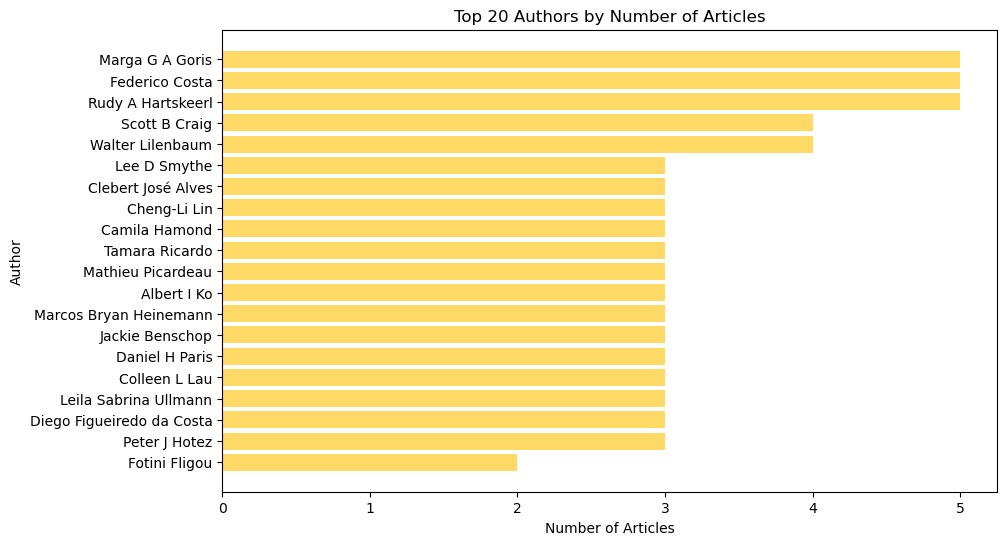

In [46]:
# Plot the top 20 authors
top_20_authors = authors_count_total.head(20)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_20_authors['Author'], top_20_authors['Count'], color='#ffd966')

# Add labels and title
plt.xlabel('Number of Articles')
plt.ylabel('Author')
plt.title('Top 20 Authors by Number of Articles')

# Display the plot
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()
